# **Random Forest를 이용한 Odor 분석**
---

In [1]:
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**
---

In [11]:
%%R

#install.packages("corrplot")                  
#install.packages("PerformanceAnalytics")      # 상관분석 시각화
#install.packages("caret")    # trainControl 
#install.packages("car")      # 다중공산성  
#install.packages("e1071")    # SVM
# install.packages("mice")    # M.I 결측치 대체
# install.packages("stringr")
# install.packages("randomForest")

library(randomForest)
library(mice)
library(stringr)
library(e1071)      
library(corrplot)
library(PerformanceAnalytics)
library(caret)
library(car)

R[write to console]: Installing package into ‘/content/drive/MyDrive/R packages’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/randomForest_4.6-14.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 80074 bytes (78 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: 

## **1. Data Preparation** 
---

### **1) Read and Select to variable (odo)** 

In [4]:
%%R

getwd()
#od <- read.csv("drive/MyDrive/PLS_양돈 농가/s1.csv", fileEncoding = "euc-kr")
od <- read.csv("drive/MyDrive/PLS_양돈 농가/s2.csv", fileEncoding = "euc-kr")
#od <- read.csv("drive/MyDrive/PLS_양돈 농가/s3.csv", fileEncoding = "euc-kr")
#od <- read.csv("drive/MyDrive/PLS_양돈 농가/s4.csv", fileEncoding = "euc-kr")
head(od)

    측정일 농장명 complex.odor Ammoina Hydorgen.sulfide Methyl.mercaptan
1 18.04.24   양지          300    0.62            310.0            19.40
2 18.04.24   양지          300    0.56            145.0             0.09
3 18.05.01   양지          310    1.79            107.0             9.24
4 18.05.01   양지          100    0.71            189.0            13.40
5 18.05.08   양지         2080    1.02            344.0             0.07
6 18.05.08   양지          448    0.97             90.5             0.07
  Dimethyl.sulfide Dimethyl.disulfide Acetic.acid Propionic.acid
1           462.00               0.05      916.52        1055.96
2            12.80               0.05       30.60          17.57
3             6.62               0.32          NA             NA
4             9.14               0.13          NA             NA
5            13.00               0.63      490.79         570.61
6            63.90               0.02      663.42         737.23
  iso.Butryic.aicd Butricy.aicd iso.Valeric.acid Val

In [5]:
%%R

### 측정일, 농장명 변수 제거

odo <- subset(od, select = -c(측정일, 농장명))
head(odo)
str(odo)

'data.frame':	29 obs. of  16 variables:
 $ complex.odor      : int  300 300 310 100 2080 448 310 669 300 300 ...
 $ Ammoina           : num  0.62 0.56 1.79 0.71 1.02 0.97 1.18 0.98 1.5 0.95 ...
 $ Hydorgen.sulfide  : num  310 145 107 189 344 90.5 312 61.4 457 261 ...
 $ Methyl.mercaptan  : num  19.4 0.09 9.24 13.4 0.07 0.07 0.07 0.07 0.07 0.07 ...
 $ Dimethyl.sulfide  : num  462 12.8 6.62 9.14 13 63.9 0.07 0.07 0.07 30.5 ...
 $ Dimethyl.disulfide: num  0.05 0.05 0.32 0.13 0.63 0.02 0.02 0.02 0.02 0.02 ...
 $ Acetic.acid       : num  916.5 30.6 NA NA 490.8 ...
 $ Propionic.acid    : num  1056 17.6 NA NA 570.6 ...
 $ iso.Butryic.aicd  : num  109.07 2.78 NA NA 51.09 ...
 $ Butricy.aicd      : num  977.4 10.8 NA NA 719.3 ...
 $ iso.Valeric.acid  : num  319.49 3.64 NA NA 168.48 ...
 $ Valeric.acid      : num  619.49 7.72 NA NA 237.64 ...
 $ Phenol            : num  30.51 2.84 NA NA 8.9 ...
 $ p.Cresol          : num  137.81 0.04 NA NA 60.56 ...
 $ Indole            : chr  "3.6" "0.04" "" ""

### **2) 결측치 확인 및 처리**

#### **a. 결측값을 평균값으로 대체**

In [6]:
# %%R


# ### 공백을 NA 값 취급
# odo <- replace(odo, odo == "", NA)


# ### 숫자변수가 문자변수로 잘못 입력된 변수를 숫자형으로 변환

# indx <- sapply(odo, is.character)
# odo[indx] <- lapply(odo[indx], function(x) as.numeric(as.character(x)))
# # str(odo)

# ### 결측치 확인

# odo<- replace(odo, odo == "ND", NA)

# if (sum(is.na(odo)) == 0) {
#     cat("결측치 개수 :", sum(is.na(odo)), "개")
# }else{
#     cat("- 평균으로 결측치 대체 - \n 결측치 대체 개수 :", sum(is.na(odo)), "개")
 
#     for(i in 1:ncol(odo)){
#         odo[is.na(odo[,i]),] <- round(mean(odo[,i], na.rm = T),3)
#         }
#     cat("\n ->", sum(is.na(odo)), "개")
# }



#### **b. ND - > 0, 결측 -> M.I**

In [7]:
%%R

### 공백을 NA 값 취급
odo <- replace(odo, odo == "", NA)


### 결측치 확인
nd <- sum(str_count(odo, "ND"))
na <- sum(is.na(odo))

cat("NA , NA 개수 :", (na+nd), "개 \n \n")


if ((nd + na) == 0) {
    print("결측치 개수 : 0 개")
}else{
    
    # "ND" 먼저 제거 (그래야 ND와 문자열 공백(NA)구분 가능)
    cat("'ND' 개수 :", nd, "개")
    odo <- replace(odo, odo == "ND", 0)
    cat("->", sum(str_count(odo, "ND")), "개 (0으로 대체) \n \n")

    # 문자열을 숫자열로 변환(공백 문자를 NA로 바꾸기 위해서)
    indx <- sapply(odo, is.character)
    odo[indx] <- lapply(odo[indx], function(x) as.numeric(as.character(x)))

    cat("결측치 개수 :", na, "개")
    imp <- mice(odo)      # M.I 사용
    odo <- complete(imp)
    cat("\n ->", sum(is.na(odo)), "개 (M.I로 대체)")
}

NA , NA 개수 : 25 개 
 
'ND' 개수 : 5 개-> 0 개 (0으로 대체) 
 
결측치 개수 : 20 개
 iter imp variable
  1   1  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol  Indole  Skatole
  1   2  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol  Indole  Skatole
  1   3  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol  Indole  Skatole
  1   4  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol  Indole  Skatole
  1   5  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol  Indole  Skatole
  2   1  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.acid  Phenol  p.Cresol  Indole  Skatole
  2   2  Acetic.acid  Propionic.acid  iso.Butryic.aicd  Butricy.aicd  iso.Valeric.acid  Valeric.ac

### **3) Data visualizations**



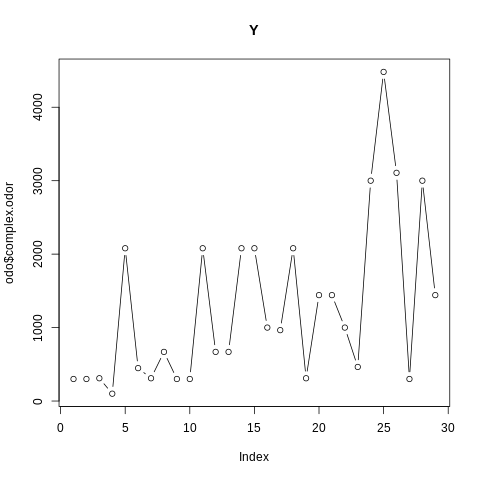

In [8]:
%%R

### 반응변수

plot(odo$complex.odor, type = "b", main = "Y")

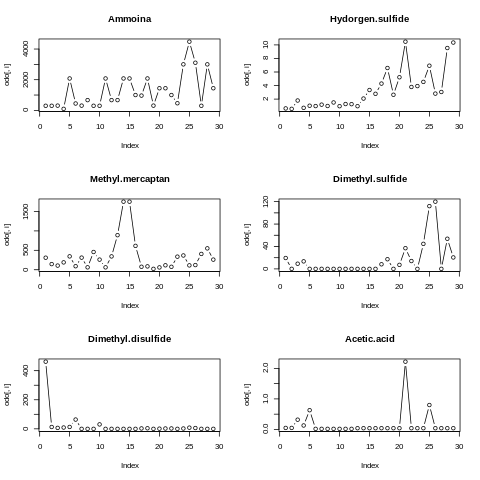

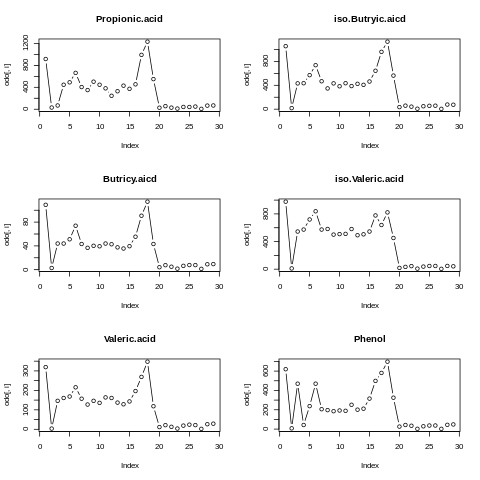

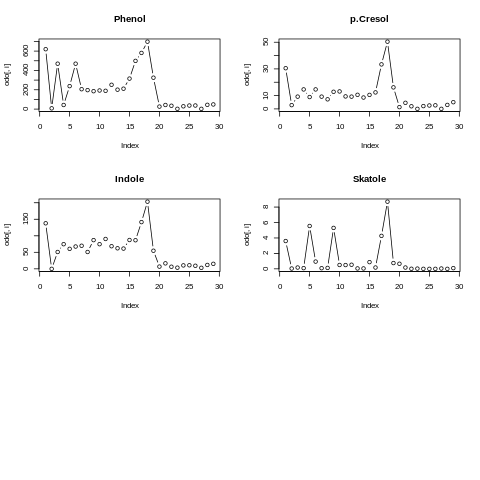

In [9]:
%%R

### 설명변수

par(mfrow = c(3,2))
for (i in c(1:6)) {
    plot(odo[,i], type = "b" , main = names(odo)[i+1])
}

for (i in c(7:12)) {
    plot(odo[,i], type = "b" , main = names(odo)[i+1])
}

for (i in c(12:15)) {
    plot(odo[,i], type = "b" , main = names(odo)[i+1])
}

par(mfrow = c(1,1))

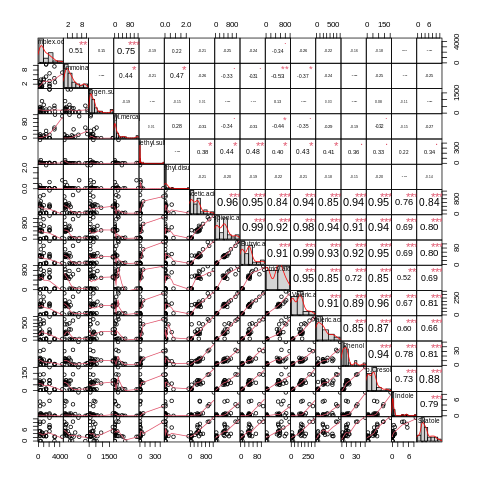

In [10]:
%%R

# as.data.frame(round(cor(odo),4))

chart.Correlation(odo, histogram = T, pch = 19)

## **2. RandomForest**


### **1) trainControl (LOOCV)**

In [13]:
%%R

control <- trainControl(method = "LOOCV",
                        repeats = 5)

### **2) random forest**

In [24]:
%%R

tunegrid <- expand.grid(.mtry = (1:15))

rf <- train(complex.odor ~ . ,
            data = odo,
            method = "rf",
            ntree = 500,
            search = "grid",
            tuneGrid = tunegrid,
            trControl = control)
rf

Random Forest 

29 samples
15 predictors

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 28, 28, 28, 28, 28, 28, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   1    892.0599  0.3425926  765.9285
   2    834.6187  0.4278515  724.7759
   3    836.4602  0.4261291  723.3611
   4    814.7827  0.4523722  691.6820
   5    803.6236  0.4664299  679.1550
   6    814.5845  0.4482255  680.8873
   7    803.9124  0.4612083  670.5492
   8    808.6673  0.4520740  670.1810
   9    808.1077  0.4530023  670.5170
  10    810.9940  0.4479842  662.5579
  11    823.1751  0.4311368  674.1785
  12    816.8708  0.4399225  662.7069
  13    828.5494  0.4241883  674.6480
  14    833.4987  0.4175392  681.5895
  15    834.7371  0.4168906  672.7727

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 5.


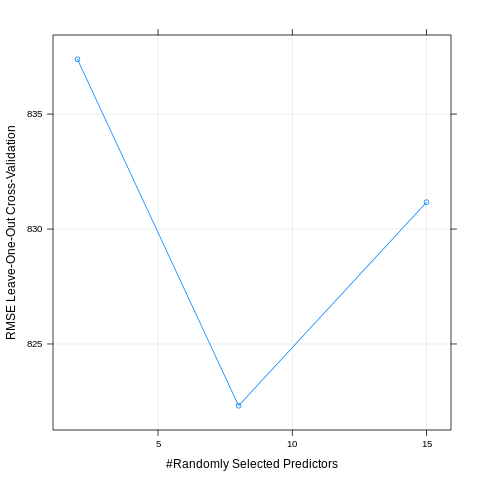

In [20]:
%%R

plot(rf)

In [25]:
%%R

rf$bestTune

  mtry
5    5


### **3) $R^2 값$

In [26]:
%%R

rf$result

   mtry     RMSE  Rsquared      MAE
1     1 892.0599 0.3425926 765.9285
2     2 834.6187 0.4278515 724.7759
3     3 836.4602 0.4261291 723.3611
4     4 814.7827 0.4523722 691.6820
5     5 803.6236 0.4664299 679.1550
6     6 814.5845 0.4482255 680.8873
7     7 803.9124 0.4612083 670.5492
8     8 808.6673 0.4520740 670.1810
9     9 808.1077 0.4530023 670.5170
10   10 810.9940 0.4479842 662.5579
11   11 823.1751 0.4311368 674.1785
12   12 816.8708 0.4399225 662.7069
13   13 828.5494 0.4241883 674.6480
14   14 833.4987 0.4175392 681.5895
15   15 834.7371 0.4168906 672.7727


In [27]:
%%R

max(rf$results$Rsquared)

[1] 0.4664299
